In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import erf

sys.path.insert(0, os.path.join("..", "..", "..", "estimators"))

from entropy_estimators import mi

plt.rc("text", usetex=True)

In [2]:
n_list = [200, 500, 1_000, 2_000]
n_iter = 2_000

n_high = 100_000

rho = 0.8
mu = np.zeros(2)
sigma = np.array([[1, rho], [rho, 1]])

In [3]:
def gauss_cdf(x, mu, sigma):
    return 0.5 * (1 + erf((x-mu)/(np.sqrt(2)*sigma)))

def uniform_reparam(x, mus=0., sigmas=1.):
    if isinstance(mus, (int, float)):
        mus = [mus] * x.shape[1]
    if isinstance(sigmas, (int, float)):
        sigmas = [sigmas] * x.shape[1]
    
    y = x.copy()
    for k in range(y.shape[1]):
        y[:, k] = gauss_cdf(y[:, k], mus[k], sigmas[k])
    
    return y

def exp_invcdf(u, lamda):
    # CDF: u = 1 - np.exp(-lamda*x)
    return - np.log(1-u) / lamda

In [4]:
distrib_dict = {
    "normal": lambda sz: np.random.multivariate_normal(mu, sigma, size=sz),
    "uniform": lambda sz: uniform_reparam(np.random.multivariate_normal(mu, sigma, size=sz)),
    "exponential": lambda sz: exp_invcdf(
        uniform_reparam(np.random.multivariate_normal(mu, sigma, size=sz)), 1
    ),
}

In [6]:
mi_mean_dict = {dist: [] for dist in distrib_dict}
mi_true_dict = {dist: None for dist in distrib_dict}
for dist in mi_mean_dict:
    print(dist)

    data = distrib_dict[dist](n_high)
    mi_true_dict[dist] = mi(data[:, 0], data[:, 1])

    for n in n_list:

        mis = []
        for _ in tqdm(range(n_iter)):
        
            data = distrib_dict[dist](n)
            mis.append(
                mi(data[:, 0], data[:, 1])
            )

        mi_mean_dict[dist].append(np.mean(mis))
    print()

normal


100%|██████████| 2000/2000 [00:12<00:00, 165.15it/s]



uniform


100%|██████████| 2000/2000 [00:12<00:00, 160.78it/s]



exponential


100%|██████████| 2000/2000 [00:12<00:00, 165.08it/s]

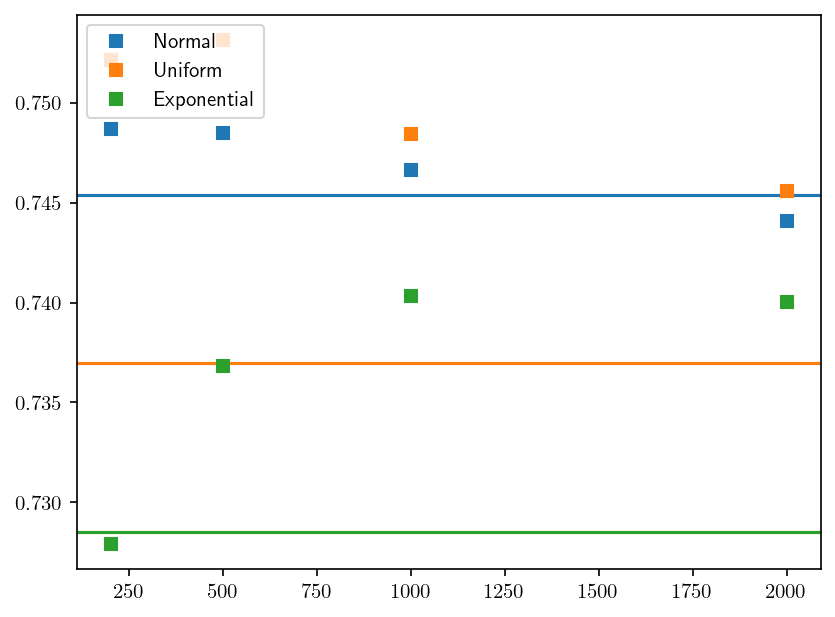

In [10]:
plt.figure(dpi=150)

for dist, means in mi_mean_dict.items():
    Nis = np.array(n_list)

    lines = plt.plot(Nis, means, linestyle="none", marker="s", label=dist.capitalize())
    
    linecolor = lines[0].get_color()
    plt.axhline(mi_true_dict[dist], color=linecolor)

plt.legend(loc="upper left")
plt.show()